In [23]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import urllib
from IPython.display import Image
from IPython.core.display import HTML 



In [24]:
csvfile = open("Skinnytaste.csv", "w")
csvwriter = csv.writer(csvfile)
csvwriter.writerow(["name", "summary", "calories", "blue","green","purple","image", "key"])


51

# Data scrape and filter

In [25]:
def filterIrrelevantArticles(soup):
    articleList = soup.find_all("article")
    #articles that are recipes have classes inside that are "icons" or "recipe-meta"
    #find out if article has those and if not, it is an irrelevant article that can be removed from list
    
    for article in articleList:
        foundIcons = False
        for child in article.children:
            if child.name == "div" and child.has_attr("class"):
                if child.get("class")[0] == "post-meta":
                    for grandchild in child.children:
                        if grandchild.get("class")[0] == "icons" or grandchild.get("class")[0] == "recipe-meta":
                            foundIcons = True
                            break
        if foundIcons == False:
            articleList.remove(article)
            
    return articleList
         

In [26]:
def writetocsv(soup):
        #find all blue/green/purple points, calories, summaries and save into lists
        #also save all articles and filter relevant articles for comparison to get rid of articles that are not recipes
        blist = soup.find_all("span", class_="smart-points blue")
        glist = soup.find_all("span", class_="smart-points green")
        plist = soup.find_all("span", class_="smart-points purple")
        namelist = soup.find_all("h2", class_="title")
        callist = soup.find_all("span", class_="icon-star")
        summarylist = soup.find_all("p", class_="excerpt")
        imglist = []
        imgstrings = []
        relevantArticles = filterIrrelevantArticles(soup)
        allArticles = soup.find_all("article", {"class":["post teaser-post odd", "post teaser-post even"]})
    
        for article in relevantArticles:
            imgSrc = article.find('a').img.get('src')
            imglist.append(imgSrc)
            imgstring = urllib.parse.quote(imgSrc,safe=":/.-_")
            imgstrings.append(imgstring)
        for article, Post, summary in zip(allArticles, namelist, summarylist):
            if article not in relevantArticles:
                namelist.remove(Post)
                summarylist.remove(summary)
        #remove first item in calories and points, because we enter the first item manually since the article structure is different      
        callist.pop(0)
        blist.pop(0)
        glist.pop(0)
        plist.pop(0)
        
        #loop through each of the lists and write as rows into my csv file
        for Post, bplist, gplist, pplist, clist, slist, img in zip(namelist, blist,glist,plist, callist, summarylist, imgstrings):        
                pn=Post.text
                cals = clist.text
                summary = slist.text
                bp = bplist.text
                gp = gplist.text
                pp = pplist.text
                #print(img)
                csvwriter.writerow([pn,summary,cals,bp, gp, pp, img])

In [27]:
page = "https://www.skinnytaste.com"
#loop 30 times, for each page on the website. read in as beautifulsoup and write relevant data into a csv file
for i in range(1,31):
    if i == 1:
        source = requests.get(page).text
        soup = BeautifulSoup(source, "lxml")
        #print(soup.prettify())
        #Manually insert first row in csv file because its style is different from the rest of the posts
        firstPostName = soup.find("div",class_="post-title").h1.text
        #firstsummary = soup.find("p")
        bluepoint = soup.find("span", class_="smart-points blue").text
        greenpoint = soup.find("span", class_="smart-points green").text
        purplepoint = soup.find("span", class_="smart-points purple").text        
        csvwriter.writerow([firstPostName, "", "", bluepoint,greenpoint,purplepoint])
        writetocsv(soup)
    if i > 1:
        numpage = "https://www.skinnytaste.com/page/{}/"
        numpage = numpage.format(i)
        source = requests.get(numpage).text
        soup = BeautifulSoup(source, "lxml")
        writetocsv(soup)

In [28]:
csvfile.close()

## Charts

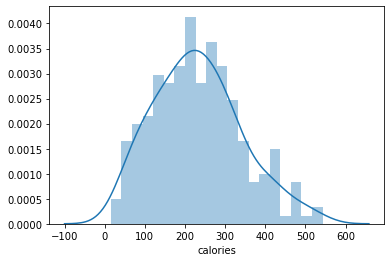

In [29]:
def createCalChart():
    bins = []
    for i in range(0,500,5):
        bins.append(i)
    frame = pd.read_csv("Skinnytaste.csv", encoding="latin-1")
    sb.distplot(frame.calories, bins=20)
createCalChart()

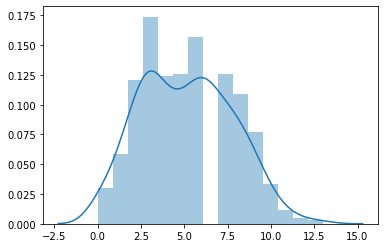

In [30]:
def createPntChart():
    frame = pd.read_csv("Skinnytaste.csv", encoding="latin-1")
    sb.distplot([frame.blue,frame.green,frame.purple])
    #sb.barplot(x="x",y="y",data=frame.blue)
        
        
createPntChart()

# User interaction

In [33]:
#code for user interaction
#prints 5 first names+summaries within specified calorie range
def printByCal(calrangemin, calrangemax, color, pntmin, pntmax):
    pd.set_option('display.max_colwidth', None)
    df = pd.read_csv("Skinnytaste.csv", encoding = "latin-1")
    if color == "blue":
        df2 = df[["name", "summary", "calories", "blue", "image"]].copy()
    elif color == "green":
        df2 = df[["name", "summary", "calories", "green","image"]].copy()
    elif color == "purple":
        df2 = df[["name", "summary", "calories", "purple","image"]].copy()
    df2 = df2.sort_values(by=["calories"])
    for i in range(0,5):
        for index, row in df2.iterrows():
            if row["calories"] >= calrangemin and row["calories"] <= calrangemax and row[color] >= pntmin and row[color] <= pntmax:
                urlstring = row["image"]
                #print(urlstring)
                #print(df2.iloc(index,:-1))
                print(row)
                i = Image(url=urlstring, width=100, height=100)
                display(i)
                df2 = df2.drop(index)
                break
    
    

In [34]:
print("Enter calorie minmum value: ")
calrangmin = int(input())
print("Enter calorie maximum value: ")
calrangmax = int(input())
print("Enter point color (blue, green, purple): ")
color = input()
print("Enter minimum point value: ")
pointmin = int(input())
print("Enter maximum point value: ")
pointmax = int(input())

printByCal(calrangmin, calrangmax, color, pointmin, pointmax)

Enter calorie minmum value: 
220
Enter calorie maximum value: 
350
Enter point color (blue, green, purple): 
green
Enter minimum point value: 
2
Enter maximum point value: 
8
name                                                                                                                                                            Spicy Shrimp Fried Rice
summary     Spicy Shrimp Fried Rice made healthier using leftover cooked brown rice, a delicious whole grain thats high in fiber, so it fills you up. Spicy Shrimp Fried Rice Fried...
calories                                                                                                                                                                            220
green                                                                                                                                                                                 5
image                                                                                    

name                                                                                                                                                                                Pumpkin Cream Cheese Muffins
summary     Pumpkin Cream Cheese Muffins are moist, delicious and perfectly spiced! A delicious fall breakfast made with canned pumpkin, pumpkin spice and a cream cheese swirl topping. Pumpkin Cream Cheese...
calories                                                                                                                                                                                                     221
green                                                                                                                                                                                                          5
image                                                                                                          https://www.skinnytaste.com/wp-content/uploads/2019/1

name                                                                                                                                       Baked Corn and Crab Cakes
summary     Deliciously Baked Corn and Crab Cakes made with lump crab and sweet summer corn. Bake them in the oven or air fryer! Baked Corn and Crab Cakes If you...
calories                                                                                                                                                         223
green                                                                                                                                                              6
image                                                         https://www.skinnytaste.com/wp-content/uploads/2012/08/Skinnytaste-Baked-Corn-Crab-Cakes-6-260x390.jpg
Name: 178, dtype: object


name                                                                                                                                                                                                 Mashed Cauliflower
summary     Mashed Cauliflower is essentially a creamy cauliflower puree that makes a delicious low-carb or keto alternative to mashed potatoes. Mashed Cauliflower If youre not concerned about cutting the carbs,...
calories                                                                                                                                                                                                            225
green                                                                                                                                                                                                                 6
image                                                                                                                     https://www.sk

name                                                                                                                                                     Zaatar Roasted Carrot and Chickpea Yogurt Bowls
summary     Roasted Carrots and Chickpeas seasoned with zaatar and served over Greek yogurt with lemony kale makes a wonderful side dish or meatless main! Zaatar Roasted Carrots and Chickpeas Ive...
calories                                                                                                                                                                                              225
green                                                                                                                                                                                                   4
image                                                                              https://www.skinnytaste.com/wp-content/uploads/2020/03/Za_atar-Roasted-Carrots-and-Chickpea-Yogurt-Bowls-4-26